<a href="https://colab.research.google.com/github/hellocybernetics/Tensorflow-Probability-Tutorials/blob/master/tutorials/00_lowlevel/basic_tensorflow_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
tfd = tfp.distributions
tfb = tfp.bijectors
tf.enable_eager_execution()

### 正規分布
$$
\begin{align}
\mathcal N(x\mid \mu, \sigma) &= Z^{-1} \exp \left( -\frac{ (x - \mu)^2} {2 \sigma^2}\right) \\\
Z &= \sqrt{2 \pi \sigma^2}
\end{align}
$$

In [0]:
normal = tfd.Normal(loc=0, scale=1.0)

#### 標準正規分布からのサンプリング
$\mu = 0, \sigma=1$の場合を標準正規分布と呼ぶ。
データを実際に1000個サンプリングして、プロットしてみる。

$$
x \sim \mathcal N(x\mid 0,1) 
$$

(array([  1.,   5.,   7.,  18.,  46.,  91., 131., 169., 189., 146.,  99.,
         61.,  29.,   7.,   1.]),
 array([-3.67569184, -3.21329405, -2.75089625, -2.28849845, -1.82610065,
        -1.36370285, -0.90130506, -0.43890726,  0.02349054,  0.48588834,
         0.94828614,  1.41068393,  1.87308173,  2.33547953,  2.79787733,
         3.26027513]),
 <a list of 15 Patch objects>)

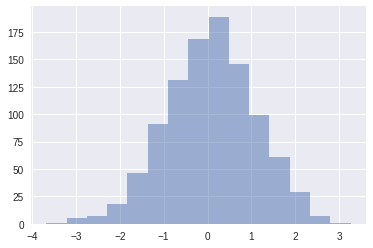

In [4]:
samples = normal.sample(1000)
plt.hist(samples.numpy(), bins=15, alpha=0.5)

#### 尤度の計算
サンプリングされた実現値 $x_i$ の尤度 ${\rm likelihood}(x_i, \mu, \sigma)$ は下記の式で計算できる。

$$
\begin{align}
{\rm likelihood}(x_i, \mu, \sigma)& =  \mathcal N(x_i∣\mu ,\sigma) \\
& =\frac{1}{\sqrt{2\pi \sigma^2}} \exp \left(−\frac{(x_i - \mu)^2}{2\sigma^2}\right)
\end{align}
$$

これは単に正規分布の式に$x_i$を代入しているだけである。これで、$x_i$が実現して手元に手に入る確率が計算される。仮に N個のサンプル $D =\{x_1, \cdots, x_N\} $ を観測したのであれば、$D$ 全体の尤度 ${\rm likelihood} (D)$は、それぞれのデータの尤度の積である。

$$
\begin{align}
{\rm likelihood}(D, \mu, \sigma)& = \prod_{i=1}^N \mathcal N(x_i∣\mu, \sigma) \\
& =\prod_{i=1}^N \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left(−\frac{(x_i-\mu)^2}{2\sigma^2}\right)
\end{align}
$$

こうしていいのは、各々のデータ $x_i $は互いに独立であると考えているためである。通常の場合 $D$ をよく表すような確率分布を決めるために $\mu, \sigma$を求めることを推定と呼ぶ。尤度が大きくなるような $\mu, \sigma$ を選ぶことができたら、$ D $ を出現させる確率が高い確率分布を（正規分布の中から）見つけたと言える。

これを最尤推定と呼ぶ。尤度を $D$ を既知として固定し、$\mu, \sigma$を変えることで最大化するわけだが、$\prod_{i=1}^N$がなかなか曲者に見える。


#### 対数尤度
そこで最大化では通常、対数尤度と呼ばれる下記の式を代わりに使う。

$$
{\rm log\ likelihood}(D, \mu, \sigma)
=-\frac{N}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^N (x_i-\mu)^2  
$$

単に尤度の対数を取っただけである。対数を取ると「掛け算は足し算」、「割り算は引き算」、「累乗は掛け算」になることを使えば簡単に上記の式が出てくる。

In [5]:
likelihood = normal.log_prob(samples)
print("log likelihood of each data \n", likelihood.numpy()[0:10])
print("log likelihood of whole data \n", likelihood.numpy().sum())

log likelihood of each data 
 [-1.0135447 -1.3056052 -1.1517067 -1.1054411 -0.9553835 -1.924545
 -1.3973554 -2.063117  -1.2424215 -3.0108275]
log likelihood of whole data 
 -1438.2146


#### TensorFlow Probabilityで最尤推定実践

(array([ 3.,  5., 15., 34., 27., 41., 33., 37., 36., 30., 24.,  7.,  3.,
         2.,  3.]),
 array([-1.03591585, -0.34811122,  0.33969342,  1.02749805,  1.71530269,
         2.40310733,  3.09091196,  3.7787166 ,  4.46652123,  5.15432587,
         5.8421305 ,  6.52993514,  7.21773977,  7.90554441,  8.59334904,
         9.28115368]),
 <a list of 15 Patch objects>)

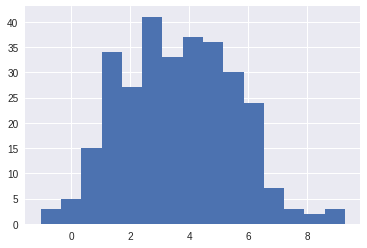

In [6]:
real_data = tfd.Normal(loc=3.5, scale=2.0).sample(300)
plt.hist(real_data, bins=15)

In [0]:
mu = tf.Variable(0.)
sigma = tf.Variable(1.)

def log_likelihood(obs_data, variable_loc, variable_scale):
    model_dist = tfd.Normal(loc=variable_loc, scale=variable_scale)
    return tf.reduce_sum(model_dist.log_prob(obs_data))

loss = lambda mu, sigma: - log_likelihood(obs_data=real_data, 
                                          variable_loc=mu, 
                                          variable_scale=sigma)

In [29]:
optimizer = tf.train.AdamOptimizer()
value_and_grads = tf.contrib.eager.implicit_value_and_gradients(loss)

for i in range(10000):
    loss, grads = value_and_grads(mu, sigma)
    optimizer.apply_gradients(grads)
    
    if i % 1000 == 0:
        print("likelihood ", -loss.numpy())

likelihood  -2798.1853
likelihood  -1115.3448
likelihood  -839.0244
likelihood  -730.2854
likelihood  -675.32416
likelihood  -643.6939
likelihood  -625.5758
likelihood  -619.2915
likelihood  -618.7661
likelihood  -618.7619


In [0]:
trained_dist = tfd.Normal(loc=mu, scale=sigma)
trained_sample = trained_dist.sample(300)

(array([ 7.,  8.,  9., 18., 32., 38., 42., 43., 30., 26., 22., 15.,  6.,
         1.,  3.]),
 array([-1.1429944 , -0.46465575,  0.21368291,  0.89202156,  1.57036022,
         2.24869887,  2.92703753,  3.60537618,  4.28371483,  4.96205349,
         5.64039214,  6.3187308 ,  6.99706945,  7.67540811,  8.35374676,
         9.03208542]),
 <a list of 15 Patch objects>)

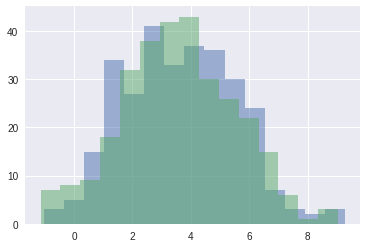

In [31]:
plt.hist(real_data, bins=15, alpha=0.5)
plt.hist(trained_sample, bins=15, alpha=0.5)